In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.multiclass import MechanizedOneVSRest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
# Hyperparameter selection on one split
import sys
sys.path.append("..")
from mechanism.mechanized_models import Mechanism
from mechanism.mechanized_models import MechanizedGaussianNB, MechanizedLogisticRegression, MechanizedOneVSRest, MechanizedDecisionTree
from mechanism.mechanized_models import MechanizedGridSearchCV


In [4]:
# Basic preprocessing
def preprocess(df):
    df_new = df.copy()
    
    # Discard identifiers, style information, timestamps
    df_new = df_new[df_new.columns.difference(['image', 'style', 'reviewTime', 
                                               'reviewerID', 'asin', 'reviewerName', 'unixReviewTime'])]

    # Turn category into binary features
    for cat in df_new.category.unique():
        df_new[cat] = df_new['category'] == cat

    # Drop category column
    df_new.drop(columns=['category'], inplace=True)

    # NaN vote is 0 users found helpful
    df_new.vote.fillna(0, inplace=True)
    
    # Turn vote into binary feature
    df_new.vote = df_new.vote > 0
    # df_new.vote.clip(0, 10)
    # df_new.vote = df_new.vote / 10

    # NaN summary is empty summary
    df_new.summary.fillna('', inplace=True)

    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [5]:
def apply_tfidf(df, review_vectorizer, summary_vectorizer):
    review_matrix = pd.DataFrame(data=review_vectorizer.transform(df.reviewText).toarray(), columns='R_' + review_vectorizer.get_feature_names_out())
    summary_matrix = pd.DataFrame(data=summary_vectorizer.transform(df.summary).toarray(), columns='S_' + summary_vectorizer.get_feature_names_out())
    df_new = pd.concat([df, review_matrix, summary_matrix], axis=1)
    df_new.drop(columns=['summary', 'reviewText'], inplace=True)
    return df_new

In [7]:
training_df = pd.read_csv('../data/Training.csv')
test_df = pd.read_csv('../data/Test.csv')

# Processing the data

In [8]:
# Preprocessing of training data
proc_training_df = preprocess(training_df)

# Set X and y
X = proc_training_df.drop('overall', axis=1)
y = proc_training_df['overall']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [ ]:
X

,verified,vote,automotive,CDs,grocery,cell_phones,sports,toys,R_00,R_000,...,S_zest,S_zest far,S_zest far inferior,S_zimmer,S_zipper,S_zippers,S_zoom,S_zz,S_zz greatest,S_zz greatest hits
0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.02]
relcols

Index(['verified', 'vote', 'R_10', 'R_20', 'R_30', 'R_30 days', 'R_50', 'R_99',
       'R_absolutely loves', 'R_actually',
       ...
       'S_worth', 'S_worth money', 'S_worthless', 'S_wouldn', 'S_yuck',
       'S_yuk', 'S_yum', 'S_yummy', 'S_zero', 'S_zero stars'],
      dtype='object', length=1099)

In [10]:
# We will go with these columns.
X = X[relcols]

In [11]:
# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Gaussian NB OVR

In [16]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
estimator = MechanizedGaussianNB()
estimator.choose_mechanism(Mechanism.GAUSSIAN)
gs_cls = MechanizedOneVSRest(estimator = estimator)
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_GS = {'estimator__var_smoothing': np.logspace(-2, -9, num = 2)}
gs_GS = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_GS, cv = 2, verbose=2, scoring='f1_macro')
gs_GS.choose_mechanism(Mechanism.GAUSSIAN)

gs_GS.fit(X_train, y_train)

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ......................estimator__var_smoothing=0.01; total time=   3.8s
[CV] END ......................estimator__var_smoothing=0.01; total time=   3.1s
[CV] END .....................estimator__var_smoothing=1e-09; total time=   3.8s
[CV] END .....................estimator__var_smoothing=1e-09; total time=   3.2s


MechanizedGridSearchCV(cv=2,
                       estimator=MechanizedOneVSRest(estimator=MechanizedGaussianNB()),
                       param_grid={'estimator__var_smoothing': array([1.e-02, 1.e-09])},
                       scoring='f1_macro', verbose=2)

In [17]:
gs_GS.best_params_

{'estimator__var_smoothing': 0.01}

In [19]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[:1]):
    print(f"Split {i}:")
    # Train model
    estimator = MechanizedGaussianNB(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_GS.best_params_.items()})
    estimator.choose_mechanism(Mechanism.GAUSSIAN)
    model = MechanizedOneVSRest(estimator = estimator)
    model.choose_mechanism(Mechanism.GAUSSIAN)
    
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")

Split 0:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.21564993795068008
  Accuracy: 0.2788626241863652
Average F1 score: 0.21564993795068008
Average accuracy: 0.2788626241863652


Text(33.0, 0.5, 'True label')

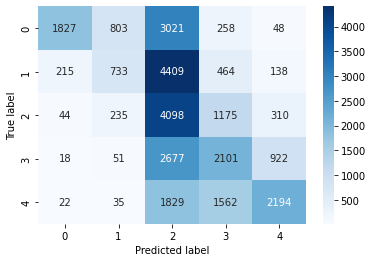

In [14]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

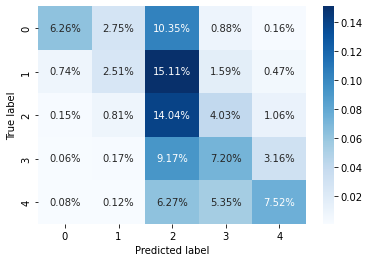

In [15]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [20]:
# Training on a new 80-20 split to compute AUC/ROC and draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_train_bin = pd.DataFrame(preprocessing.label_binarize(y_train, classes=range(1, 6)))
y_val_bin = pd.DataFrame(preprocessing.label_binarize(y_val, classes=range(1, 6)))

estimator = MechanizedGaussianNB(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_GS.best_params_.items()})
estimator.choose_mechanism(Mechanism.GAUSSIAN)

model = MechanizedOneVSRest(estimator)
model.choose_mechanism(Mechanism.GAUSSIAN)

model.fit(X_train, y_train_bin)
roc_auc_scores.append(roc_auc_score(y_val_bin, model.predict_proba(X_val)))
print(f"ROC/AUC score: {roc_auc_scores[-1]}")

in gaussian mechanism MechanizedDecisionTree
ROC/AUC score: 0.7390032195072317


in gaussian mechanism MechanizedDecisionTree
in gaussian mechanism MechanizedDecisionTree
in gaussian mechanism MechanizedDecisionTree
in gaussian mechanism MechanizedDecisionTree
in gaussian mechanism MechanizedDecisionTree


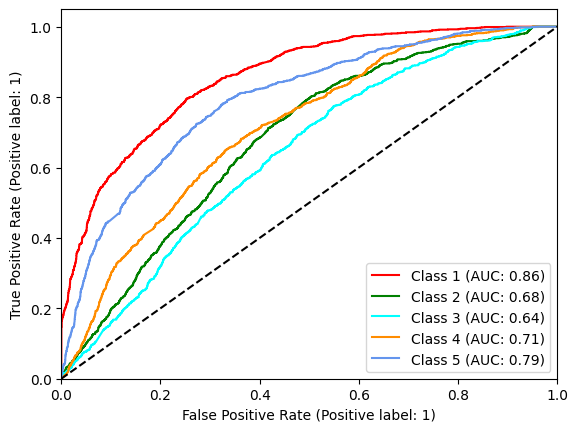

In [21]:
# ROC Curve
for i in range(5):
    estimator = MechanizedGaussianNB(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_GS.best_params_.items()})
    estimator.choose_mechanism(Mechanism.GAUSSIAN)
    model=MechanizedOneVSRest(estimator = estimator)
    model.choose_mechanism(Mechanism.GAUSSIAN)

    model.fit(X_train, y_train_bin[i])
    RocCurveDisplay.from_predictions(y_val_bin[i], model.predict_proba(X_val)[:, 1], 
                                     color=["red", "green", "aqua", "darkorange", "cornflowerblue"][i],
                                     label=f"Class {i+1} (AUC: {roc_auc_score(y_val_bin[i], model.predict_proba(X_val)[:, 1]):.2f})", ax=plt.gca())
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Logistic Regression OVR

In [22]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
estimator = MechanizedLogisticRegression(max_iter=1500)
estimator.choose_mechanism(Mechanism.GAUSSIAN)
gs_cls = MechanizedOneVSRest(estimator = estimator)
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

params_LR = {'estimator__C': np.logspace(-0.2, 0.7, num = 10)}
gs_LR = GridSearchCV(estimator=gs_cls, param_grid=params_LR, cv = 2, verbose=2, scoring='f1_macro')
gs_LR.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ....................estimator__C=0.6309573444801932; total time=   5.5s
[CV] END ....................estimator__C=0.6309573444801932; total time=   5.6s
[CV] END ....................estimator__C=0.7943282347242815; total time=   5.8s
[CV] END ....................estimator__C=0.7943282347242815; total time=   6.1s
[CV] END ....................estimator__C=0.9999999999999999; total time=   6.3s
[CV] END ....................estimator__C=0.9999999999999999; total time=   6.6s
[CV] END .....................estimator__C=1.258925411794167; total time=   7.0s
[CV] END .....................estimator__C=1.258925411794167; total time=   7.3s
[CV] END ....................estimator__C=1.5848931924611134; total time=   7.7s
[CV] END ....................estimator__C=1.5848931924611134; total time=   4.6s
[CV] END ....................estimator__C=1.9952623149688793; total time=   4.1s
[CV] END ....................estimator__C=1.9952

GridSearchCV(cv=2,
             estimator=MechanizedOneVSRest(estimator=MechanizedLogisticRegression(max_iter=1500)),
             param_grid={'estimator__C': array([0.63095734, 0.79432823, 1.        , 1.25892541, 1.58489319,
       1.99526231, 2.51188643, 3.16227766, 3.98107171, 5.01187234])},
             scoring='f1_macro', verbose=2)

In [23]:
gs_LR.best_estimator_.get_params()

{'estimator__C': 1.5848931924611134,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 1500,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': MechanizedLogisticRegression(C=1.5848931924611134, max_iter=1500),
 'n_jobs': None,
 'verbose': 0}

In [24]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    estimator = MechanizedLogisticRegression(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_LR.best_estimator_.get_params().items() 
                                                             if (k == 'estimator__C' or k == 'estimator__max_iter')})
    estimator.choose_mechanism(Mechanism.GAUSSIAN)
    
    model = MechanizedOneVSRest(estimator)
    model.choose_mechanism(Mechanism.GAUSSIAN)

    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")

Split 0:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.38689623946711393
  Accuracy: 0.3963686193902021
Split 1:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.3852397827511279
  Accuracy: 0.39379924631723195
Split 2:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.38821604800288284
  Accuracy: 0.39516957862281604
Split 3:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.3921381566408292
  Accuracy: 0.3989379924631723
Split 4:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.3821923327718343
  Accuracy: 0.39112557820798355
Average F1 score: 0.3583887495974114
Average accuracy: 0.3757106065312952


Text(50.722222222222214, 0.5, 'True label')

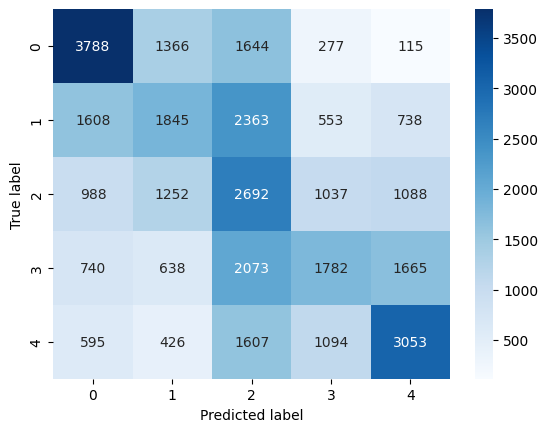

In [25]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

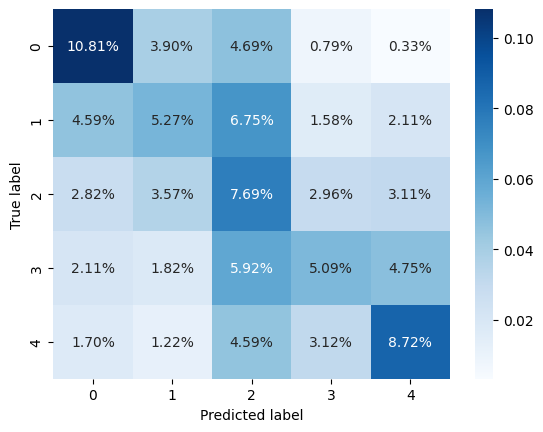

In [26]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [28]:
# Training on a new 80-20 split to compute AUC/ROC and draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_train_bin = pd.DataFrame(preprocessing.label_binarize(y_train, classes=range(1, 6)))
y_val_bin = pd.DataFrame(preprocessing.label_binarize(y_val, classes=range(1, 6)))

estimator = MechanizedLogisticRegression(**{k.split('__')[-1]: v 
                                                for (k, v) in gs_LR.best_estimator_.get_params().items() 
                                                            if (k == 'estimator__C' or k == 'estimator__max_iter')})
estimator.choose_mechanism(Mechanism.GAUSSIAN)

model = MechanizedOneVSRest(estimator)
model.choose_mechanism(Mechanism.GAUSSIAN)

model.fit(X_train, y_train_bin)
roc_auc_scores.append(roc_auc_score(y_val_bin, model.predict_proba(X_val)))
print(f"ROC/AUC score: {roc_auc_scores[-1]}")

in gaussian mechanism MechanizedDecisionTree
ROC/AUC score: 0.7342984682009859


in gaussian mechanism MechanizedDecisionTree
in gaussian mechanism MechanizedDecisionTree
in gaussian mechanism MechanizedDecisionTree
in gaussian mechanism MechanizedDecisionTree
in gaussian mechanism MechanizedDecisionTree


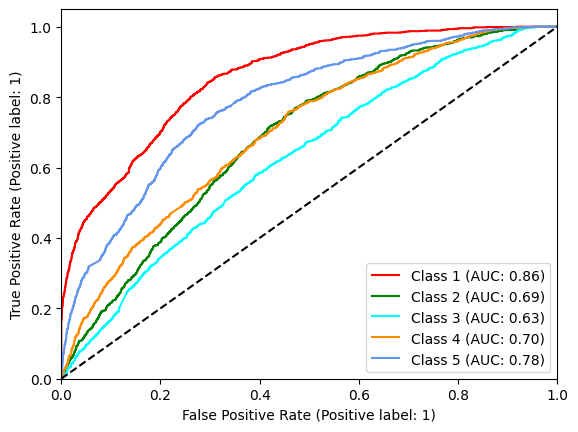

In [29]:
# ROC Curve
for i in range(5):
    estimator = MechanizedLogisticRegression(**{k.split('__')[-1]: v 
                                                  for (k, v) in gs_LR.best_estimator_.get_params().items() 
                                                             if (k == 'estimator__C' or k == 'estimator__max_iter')})
    estimator.choose_mechanism(Mechanism.GAUSSIAN)
    
    model = MechanizedOneVSRest(estimator)
    model.choose_mechanism(Mechanism.GAUSSIAN)

    model.fit(X_train, y_train_bin[i])
    RocCurveDisplay.from_predictions(y_val_bin[i], model.predict_proba(X_val)[:, 1], 
                                     color=["red", "green", "aqua", "darkorange", "cornflowerblue"][i],
                                     label=f"Class {i+1} (AUC: {roc_auc_score(y_val_bin[i], model.predict_proba(X_val)[:, 1]):.2f})", ax=plt.gca())
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

## Decision Tree Classifier OVR

In [32]:
class MechanizedGridSearchCV(GridSearchCV):    
    def __init__(self, estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch="2*n_jobs", error_score=np.nan, return_train_score=False):
        super().__init__(estimator = estimator, 
                         param_grid = param_grid, 
                         scoring=scoring, 
                         n_jobs = n_jobs,
                         refit = refit, 
                         cv = cv, 
                         verbose = verbose, 
                         pre_dispatch = pre_dispatch, 
                         error_score = error_score, 
                         return_train_score = return_train_score)
        self.mechanism = None

    def fit(self, x_train, y_train):
        if self.mechanism == None:
            result = super(MechanizedGridSearchCV, self).fit(x_train, y_train)
            if isinstance(result, GridSearchCV):
                return self
            else:
                return result
        elif self.mechanism == Mechanism.GAUSSIAN:
            print("in gaussian mechanism GridSearchCV")
            x_noise = np.random.normal(0, 0.1, x_train.shape) 
            noised_x = x_train + x_noise
            
            ################ Gaussian Noise Added to Labels ################
            # y_noise = np.random.normal(0, 0.1, y_train.shape) 
            # noised_y = y_train + y_noise
            # lab = preprocessing.LabelEncoder()
            # y_transformed = pd.Series(
            # lab.fit_transform(noised_y), 
            # y_train.index,
            # y_train.dtype,
            # y_train.name,
            # y_train.copy
            # )
            # y_transformed = lab.fit_transform(noised_y)

            result = super(MechanizedGridSearchCV, self).fit(noised_x, y_train)
            if isinstance(result, GridSearchCV):
                return self
            else:
                return result
        else:
            result = super(MechanizedGridSearchCV, self).fit(x_train, y_train)
            if isinstance(result, GridSearchCV):
                return self
            else:
                return result
    
    def choose_mechanism(self, mech):
        self.mechanism = mech

In [34]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
estimator = MechanizedDecisionTree()
estimator.choose_mechanism(Mechanism.GAUSSIAN)

gs_cls = MechanizedOneVSRest(estimator = estimator)
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

params_DT = {'estimator__criterion': ['entropy','gini'], 'estimator__max_depth': np.arange(40, 101, 15)}

gs_DT = MechanizedGridSearchCV(estimator=gs_cls, param_grid = params_DT, cv=3, verbose=2, scoring='f1_macro')
gs_DT.choose_mechanism(Mechanism.GAUSSIAN)

gs_DT.fit(X_train, y_train)

in gaussian mechanism GridSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END estimator__criterion=entropy, estimator__max_depth=40; total time= 6.6min
[CV] END estimator__criterion=entropy, estimator__max_depth=40; total time=10.7min


In [ ]:
gs_DT.best_params_

{'estimator__criterion': 'entropy', 'estimator__max_depth': 40}

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=RuntimeWarning)

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    estimator = MechanizedDecisionTree(**{k.split('__')[-1]: v 
                                                          for (k, v) in gs_DT.best_params_.items()})
    estimator.choose_mechanism(Mechanism.GAUSSIAN)
    model = MechanizedOneVSRest()
    model.choose_mechanism(Mechanism.GAUSSIAN)
    
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")

Split 0:
  F1 score: 0.36951696958338054
  Accuracy: 0.36639260020554987
Split 1:
  F1 score: 0.38067561863270344
  Accuracy: 0.37375813634806443
Split 2:
  F1 score: 0.3574074838926535
  Accuracy: 0.355258650222679
Split 3:
  F1 score: 0.37349985276786246
  Accuracy: 0.36913326481671804
Split 4:
  F1 score: 0.3604289834004305
  Accuracy: 0.35720404317286275
Average F1 score: 0.4045830535578114
Average accuracy: 0.4053352574799115


Text(33.0, 0.5, 'True label')

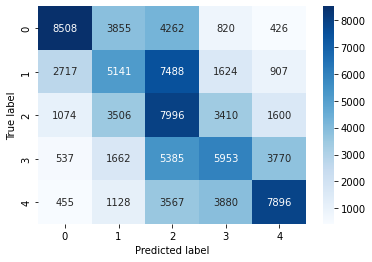

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

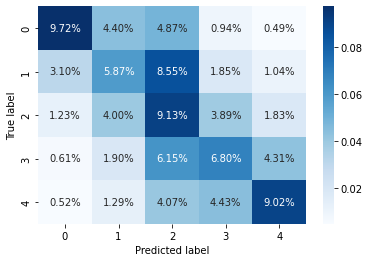

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to compute AUC/ROC and draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_train_bin = pd.DataFrame(preprocessing.label_binarize(y_train, classes=range(1, 6)))
y_val_bin = pd.DataFrame(preprocessing.label_binarize(y_val, classes=range(1, 6)))
estimator = MechanizedDecisionTree(**{k.split('__')[-1]: v 
                                                          for (k, v) in gs_DT.best_params_.items()})
estimator.choose_mechanism(Mechanism.GAUSSIAN)
model = MechanizedOneVSRest()
model.choose_mechanism(Mechanism.GAUSSIAN)

model.fit(X_train, y_train_bin)
roc_auc_scores.append(roc_auc_score(y_val_bin, model.predict_proba(X_val)))
print(f"ROC/AUC score: {roc_auc_scores[-1]}")

ROC/AUC score: 0.6476956751229161


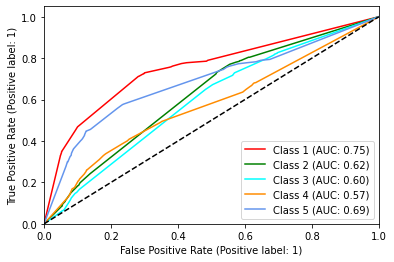

In [ ]:
# ROC Curve
for i in range(5):
    estimator = MechanizedDecisionTree(**{k.split('__')[-1]: v 
                                                          for (k, v) in gs_DT.best_params_.items()})
    estimator.choose_mechanism(Mechanism.GAUSSIAN)
    
    model = MechanizedOneVSRest(estimator = estimator)
    model.choose_mechanism(Mechanism.GAUSSIAN)

    model.fit(X_train, y_train_bin[i])
    RocCurveDisplay.from_predictions(y_val_bin[i], model.predict_proba(X_val)[:, 1], 
                                     color=["red", "green", "aqua", "darkorange", "cornflowerblue"][i],
                                     label=f"Class {i+1} (AUC: {roc_auc_score(y_val_bin[i], model.predict_proba(X_val)[:, 1]):.2f})", ax=plt.gca())
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [ ]:

estimator=MechanizedLogisticRegression(C=3.9810717055349714, max_iter=1500)
estimator.choose_mechanism(Mechanism.GAUSSIAN)

model_fin = MechanizedOneVSRest(estimator = estimator)
model_fin.choose_mechanism(Mechanism.GAUSSIAN)

model_fin.fit(X, y)

OneVsRestClassifier(estimator=LogisticRegression(C=3.9810717055349714,
                                                 max_iter=1500))

In [ ]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [ ]:
proc_test_df['predicted'] = model_fin.predict(proc_test_df)
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task2.csv', index=False)